# CatBoost

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Read data
print(os.listdir("./data"))
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

['submission_sample.csv', 'test.csv', 'Dataset Description.txt', 'train.csv']


In [2]:
# Warning "A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead" removing:
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", 50, "display.max_columns", None)

# Feature Engineering

In [3]:
# Feature types
Features=train.dtypes.reset_index()
Categorical=Features.loc[Features[0]=='object','index']

In [5]:
# Categorical to the begining
cols = train.columns.tolist()
pos=0
for col in Categorical:
	cols.insert(pos, cols.pop(cols.index(col)))
	pos+=1
train = train[cols]
cols.remove('TARGET')
test = test[cols]

In [6]:
# 1) Missings
################################################################################
# Function to print columns with at least n_miss missings
def miss(ds,n_miss):
	miss_list=list()
	for col in list(ds):
		if ds[col].isna().sum()>=n_miss:
			print(col,ds[col].isna().sum())
			miss_list.append(col)
	return miss_list
# Which columns have 1 missing at least...
print('\n################## TRAIN ##################')
m_tr=miss(train,1)
print('\n################## TEST ##################')
m_te=miss(test,1)


################## TRAIN ##################
X21 75
X1 3
X2 3
X3 3
X4 16
X5 8
X6 3
X7 3
X8 13
X9 1
X10 3
X11 3
X12 16
X14 3
X15 6
X16 13
X17 13
X18 3
X22 3
X24 95
X25 3
X26 13
X27 281
X28 80
X29 3
X32 29
X33 16
X34 13
X35 3
X36 3
X37 1794
X38 3
X40 16
X41 58
X45 188
X46 16
X47 24
X48 3
X50 13
X51 3
X52 25
X53 80
X54 80
X57 3
X59 3
X60 188
X61 10
X63 16
X64 80

################## TEST ##################
X21 28
X4 5
X5 3
X8 5
X12 5
X16 5
X17 5
X24 40
X26 5
X27 110
X28 27
X32 17
X33 5
X34 5
X37 754
X40 5
X41 26
X45 80
X46 5
X47 11
X50 5
X52 11
X53 27
X54 27
X60 80
X61 5
X63 5
X64 27


In [7]:
# Missings in categorical features (fix it with an 'NA' string)
################################################################################
for col in Categorical:
	train.loc[train[col].isna(),col]='NA'
	test.loc[test[col].isna(),col]='NA'

In [8]:
train = train[train['ID']!='A1039']
train = train[train['ID']!='A2983']
train = train[train['ID']!='A3055']
train = train[train['ID']!='A4665']

In [9]:
train.reset_index(drop=True,inplace=True)

In [10]:
# 2) Correlations
################################################################################
# Let's see if certain columns are correlated
# or even that are the same with a "shift"
thresholdCorrelation = 0.99
def InspectCorrelated(df):
	corrMatrix = df.corr().abs() # Correlation Matrix
	upperMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape),k=1).astype(np.bool))
	correlColumns=[]
	for col in upperMatrix.columns:
		correls=upperMatrix.loc[upperMatrix[col]>thresholdCorrelation,col].keys()
		if (len(correls)>=1):
			correlColumns.append(col)
			print("\n",col,'->', end=" ")
			for i in correls:
				print(i, end=" ")
	print('\nSelected columns to drop:\n',correlColumns)
	return(correlColumns)

In [11]:
# Look at correlations in the original features
correlColumns=InspectCorrelated(train.iloc[:,len(Categorical):-1])


 X7 -> X1 
 X11 -> X1 X7 
 X14 -> X1 X7 X11 
 X17 -> X8 
 X18 -> X1 X7 X11 X14 
 X22 -> X1 X7 X11 X14 X18 
 X23 -> X19 
 X25 -> X10 
 X26 -> X16 
 X34 -> X16 X26 
 X35 -> X1 X7 X11 X14 X18 X22 
 X38 -> X10 X25 
 X40 -> X4 
 X46 -> X4 X40 
 X48 -> X1 X7 X11 X14 X22 X35 
 X50 -> X4 X46 
 X52 -> X47 
 X60 -> X45 
 X63 -> X33 
Selected columns to drop:
 ['X7', 'X11', 'X14', 'X17', 'X18', 'X22', 'X23', 'X25', 'X26', 'X34', 'X35', 'X38', 'X40', 'X46', 'X48', 'X50', 'X52', 'X60', 'X63']


/var/folders/pv/21djj0qj50v927yf9fbqsnsh0000gn/T/ipykernel_3434/1828011891.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upperMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape),k=1).astype(np.bool))


In [12]:
# If we are ok, throw them:
train=train.drop(correlColumns,axis=1)
test=test.drop(correlColumns,axis=1)

In [13]:
# 3) Constants
################################################################################
# Let's see if there is some constant column:
def InspectConstant(df):
	consColumns=[]
	for col in list(df):
		if len(df[col].unique())<2:
			print(df[col].dtypes,'\t',col,len(df[col].unique()))
			consColumns.append(col)
	print('\nSelected columns to drop:\n',consColumns)
	return(consColumns)

consColumns=InspectConstant(train.iloc[:,len(Categorical):-1])


Selected columns to drop:
 []


In [14]:
# If we are ok, throw them:
train=train.drop(consColumns,axis=1)
test=test.drop(consColumns,axis=1)

# Model - CatBoost

In [15]:
pred=list(train)[1:-1]
X_train=train[pred].reset_index(drop=True)
Y_train=train['TARGET'].reset_index(drop=True)
X_test=test[pred].reset_index(drop=True)

In [22]:
# 1) For expensive models (catboost) we first try with validation set (no cv)
################################################################################
from catboost import CatBoostClassifier
from catboost import Pool

In [17]:
# train / test partition
RS=1234 # Seed for partitions (train/test) and model random part
TS=0.3 # Validation size
esr=10 # Early stopping rounds (when validation does not improve in these rounds, stops)

In [18]:

x_tr, x_val, y_tr, y_val = train_test_split(X_train, Y_train, test_size=TS, random_state=RS)

In [23]:
# Categorical positions for catboost
Pos=list()
As_Categorical=Categorical.tolist()
As_Categorical.remove('ID')
for col in As_Categorical:
    Pos.append((X_train.columns.get_loc(col)))

In [24]:
# To Pool Class (for catboost only)
pool_tr=Pool(x_tr, y_tr,cat_features=Pos)
pool_val=Pool(x_val, y_val,cat_features=Pos)

In [25]:
# By-hand paramter tuning. A grid-search is expensive
# We test different combinations
# See parameter options here:
# "https://catboost.ai/en/docs/references/training-parameters/"
model_catboost_val = CatBoostClassifier(
          eval_metric='AUC',
          iterations=500, # Very high value, to find the optimum
          od_type='Iter', # Overfitting detector set to "iterations" or number of trees
          random_seed=RS, # Random seed for reproducibility
          verbose=100) # Shows train/test metric every "verbose" trees

In [22]:
# "Technical" parameters of the model:
params = {'objective': 'Logloss',
		  'learning_rate': 0.1, # learning rate, lower -> slower but better prediction
		  'depth': 3, # Depth of the trees (values betwwen 5 and 10, higher -> more overfitting)
		  'min_data_in_leaf': 10,
		  'l2_leaf_reg': 0, # L2 regularization (between 3 and 20, higher -> less overfitting)
		  'rsm': 0.95, # % of features to consider in each split (lower -> faster and reduces overfitting)
		  'subsample': 0.95, # Sample rate for bagging
		  'random_seed': RS}

In [23]:
model_catboost_val.set_params(**params)

print('\nCatboost Fit (Validation)...\n')
model_catboost_val.fit(X=pool_tr,
                       eval_set=pool_val,
                       early_stopping_rounds=esr)


Catboost Fit (Validation)...

0:	test: 0.7837725	best: 0.7837725 (0)	total: 55.4ms	remaining: 27.6s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9611192021
bestIteration = 51

Shrink model to first 52 iterations.


In [24]:
# 4) Shap Importance for the features of the final model
################################################################################
# Shap methodology:
# "https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83"
# Catboost has already SHAP integrated
# Comes as variation with respect to LOG Odds
ShapImportance=model_catboost.get_feature_importance(data=pool_train,
												     type='ShapValues',
													 prettified=True,
													 verbose=False)
ShapValues = ShapImportance.iloc[:, :-1]
ShapValues.columns=list(X_train)

NameError: name 'model_catboost' is not defined

In [ ]:
# Picture in Logodds
################################################################################
from shap import summary_plot
num_features=30
summary_plot(ShapValues.values,X_train,max_display=num_features,plot_type='dot')

# Variable Importance Recap
################################################################################
import matplotlib.pyplot as plt
import seaborn as sns

Importance=ShapValues.abs().mean(axis=0)
Importance=pd.DataFrame({'Feature':Importance.index.tolist(),'Importance':Importance}).sort_values(by=['Importance'],ascending=False).reset_index(drop=True)
# Top features:
plt.figure(figsize=(15, 15))
sns.barplot(x="Importance",
			y="Feature",
			data=Importance[:num_features],
			palette=sns.color_palette("Blues_d",
			n_colors=Importance[:num_features].shape[0]))

## Predictions - Results

In [ ]:
# Prediction (All train model)
test['Pred']=model_catboost.predict_proba(X_test)[:,1]
catboost_submission=pd.DataFrame(test[['ID','Pred']])

# Cv predictions
catboost_cv_train=train[['ID']]
catboost_cv_train['catboost_pred']=Catboost_train['train_yhat']
catboost_cv_test=test[['ID']]
catboost_cv_test['catboost_pred']=Catboost_test['test_yhat']

# Outputs to .csv
catboost_submission.to_csv("BBDD Output/catboost_submission.csv", index = False)
catboost_cv_train.to_csv("BBDD Output/catboost_cv_train.csv", index = False)
catboost_cv_test.to_csv("BBDD Output/catboost_cv_test.csv", index = False)
Importance.to_csv("BBDD Output/catboost_importance.csv", index = False)

In [25]:
type(x_tr)

pandas.core.frame.DataFrame

# XGboost

In [26]:
x_val

,X21,X43,X55,X1,X2,X3,X4,X5,X6,X8,X9,X10,X12,X13,X15,X16,X19,X20,X24,X27,X28,X29,X30,X31,X32,X33,X36,X37,X39,X41,X42,X44,X45,X47,X49,X51,X53,X54,X56,X57,X58,X59,X61,X62,X64
2828,90%-100%,60-120 days,500 to 2000,0.127030,0.187500,0.284400,2.63190,45.98500,0.000000,4.33330,1.39830,0.81250,0.90409,0.136250,359.22,1.01610,0.112680,27.1040,0.479310,39.92800,0.52539,3.8424,0.026326,0.115100,44.577,8.1880,1.39830,NaN,-0.020482,0.032655,0.113300,52.636,1.22330,26.5600,0.089734,0.174270,1.50100,1.50100,-0.020482,0.156340,0.90114,0.000000,6.9344,45.491,2.58310
1505,>100%,30-60 days,above 2000,0.294390,0.571270,0.068046,1.12020,0.49422,0.517280,0.70034,1.15800,0.40008,0.51996,0.156830,628.22,0.58101,0.139100,8.2155,0.517280,1.58980,0.18603,4.5604,0.108830,0.139100,113.080,3.2279,2.13150,115.32000,0.137280,0.057249,0.137280,39.270,6.18000,9.5139,0.119550,0.566180,1.09380,1.10770,0.136470,0.735830,0.86353,0.012714,9.2947,97.646,5.78600
804,>100%,30-60 days,above 2000,0.084175,0.425200,0.240150,1.65160,9.00960,0.220870,1.30240,1.02770,0.55377,0.28407,0.046156,844.32,0.43230,0.026291,12.3240,0.274960,0.30482,0.61378,4.7057,0.077901,0.026291,34.716,10.5140,4.00130,8.37640,0.029661,0.070876,0.029661,31.952,0.62598,12.6650,0.009796,0.368580,1.41530,1.56000,0.026919,0.152000,0.97308,0.102240,11.4230,33.781,10.17800
2061,<75%,60-120 days,negative,-0.147900,0.717280,-0.196320,0.54446,-81.75600,0.000000,0.39415,1.35360,0.28272,-0.34318,-0.072663,-2661.80,-0.13713,-0.109260,32.5380,0.986250,-2.56360,-0.25651,5.1070,0.527960,-0.081880,107.030,3.4161,1.35360,0.49804,-0.085705,-0.394640,-0.081356,28.381,-1.22560,29.9170,-0.117950,0.430960,0.36939,0.66838,-0.085705,-0.523140,1.11930,0.809410,12.8610,116.210,1.76860
2679,>100%,30-60 days,above 2000,0.219930,0.479740,0.200800,3.47930,34.43600,0.000000,1.08440,2.24590,0.52026,3.35870,0.188220,414.24,0.88114,0.121120,2.7626,0.383140,5.61040,0.27959,4.1004,0.188850,0.131670,15.004,24.3260,2.24590,1.56030,0.122740,0.034533,0.139090,32.414,12.93800,3.1491,0.071992,0.080993,0.72439,0.96068,0.122740,0.422740,0.88933,0.326200,11.2610,13.163,3.12710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,>100%,120-240 days,above 2000,0.041292,0.245640,0.363540,2.60100,15.93400,0.015139,2.98510,1.00610,0.73327,0.20617,0.158320,613.30,0.59514,0.050697,97.9760,0.023979,0.49701,0.88801,4.0862,0.239060,0.050697,90.298,4.0422,0.98621,18.44900,0.049402,0.055697,0.049402,94.232,0.16659,98.5690,-0.058221,0.227070,1.79110,1.83650,0.006019,0.056312,0.99398,0.025335,3.8734,89.754,2.25550
2817,>100%,less 1 month,negative,0.013463,0.423130,-0.015814,0.80651,-495.15000,0.000000,1.36340,0.66028,0.57687,0.16472,0.139600,1675.60,0.21784,0.020390,12.5260,0.032427,NaN,-0.01693,4.0646,0.626440,0.045996,269.890,1.3524,0.66028,0.20079,0.019989,0.179190,0.000000,15.737,0.59413,74.8290,-0.119210,0.081730,0.61758,0.84821,0.832600,0.023338,0.16969,0.373440,23.1940,45.180,0.70688
2666,>100%,60-120 days,above 2000,0.188910,0.095661,0.474570,5.96090,69.57900,0.495370,9.45360,1.52250,0.90434,1.97480,0.166000,138.15,2.64210,0.124080,54.0080,0.599890,141.68000,1.10420,3.9677,-0.060047,0.124080,26.110,13.9790,1.52250,NaN,0.121670,0.012826,0.121360,37.086,0.83853,61.4900,0.079430,0.095661,2.10420,2.10420,0.121670,0.208890,0.87654,0.000000,9.8419,22.933,3.54260
2942,<75%,30-60 days,0 to 500,-0.365860,0.651810,0.348190,1.53420,-15.93400,0.000000,0.53417,6.87150,0.34818,-0.56130,-0.053243,-650.28,-0.56130,-0.053243,31.0750,-0.323970,NaN,NaN,1.8463,0.083115,-0.106490,39.865,9.1558,6.87150,NaN,0.000004,NaN,0.000000,16.307,-0.62538,35.7800,0.000000,0.651810,NaN,NaN,0.131510,-1.050800,0.86849,0.000000,22.3840,34.622,NaN


In [27]:
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# trasnform cat variables-one hot encoding
# extract the features and target

# one-hot encode the categorical features
cat_attribs = ['X21', 'X43', 'X55']
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')

In [28]:
encoder = full_pipeline.fit(x_tr)
X_train = encoder.transform(x_tr)
X_test = encoder.transform(x_val)

In [43]:
label = y_tr
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
dtrain = xgb.DMatrix(X_train, label=label)
dtest = xgb.DMatrix(X_test, label = y_val)

In [52]:
param = {'max_depth': 4, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

In [45]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [58]:
num_round = 100
bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=2)

[0]	eval-auc:0.84942	train-auc:0.86810
[1]	eval-auc:0.88632	train-auc:0.91388
[2]	eval-auc:0.93336	train-auc:0.95176
[3]	eval-auc:0.95331	train-auc:0.95971
[4]	eval-auc:0.94195	train-auc:0.97722
[5]	eval-auc:0.93696	train-auc:0.98603
[6]	eval-auc:0.94111	train-auc:0.98990
[7]	eval-auc:0.94183	train-auc:0.99264
[8]	eval-auc:0.93917	train-auc:0.99588
[9]	eval-auc:0.93429	train-auc:0.99830
[10]	eval-auc:0.93387	train-auc:0.99893
[11]	eval-auc:0.93841	train-auc:0.99934
[12]	eval-auc:0.93910	train-auc:0.99977
[13]	eval-auc:0.94034	train-auc:0.99994
[14]	eval-auc:0.93766	train-auc:0.99999
[15]	eval-auc:0.93815	train-auc:0.99999
[16]	eval-auc:0.93635	train-auc:1.00000
[17]	eval-auc:0.93672	train-auc:1.00000


In [59]:
# predict
ypred = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))

In [81]:
y_predicted =pd.Series(ypred).map(lambda x: 0 if x <= 0.5 else 1)

In [84]:
type(y_val)

pandas.core.series.Series

In [83]:
type(y_predicted)

pandas.core.series.Series

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

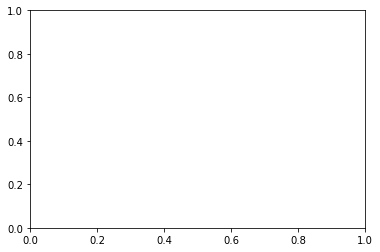

In [62]:
xgb.plot_tree(bst)